# Сравнение средних с помощью дисперсионного анализа

Приложение по доставке готовых продуктов. 

К вам пришел коллега с результатами двух тестов. В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные. Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый.

Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

### Задания:
1. Выберите метод, который предположительно подойдет в первом вопросе.
2. Проверьте, являются ли дисперсии внутри групп гомогенными.
3. Проведите тест на нормальность распределения.
4. Сравните средние в представленных группах.
5. Используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия. 
6. Примите решение: какие картинки в итоге будем использовать?
7. Выберите метод для второго теста.
8. Визуализируйте распределение events для контрольной и тестовой групп. 
9. Посмотрите на описательные статистики events в разбивке по группе и по сегменту пользователя. 
10. Выберите формулу для модели, проведите тест.


### Описание данных
**5_task_1:** \
id – id клиента в эксперименте\
group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4) \
events – сколько блюд суммарно было заказано за период

**5_task_2:**\
id – id клиента в эксперименте\
segment – сегмент (high/low)\
group – вид кнопки (control – старая версия, test – новая версия)\
events – сколько блюд суммарно было заказано за период

In [1]:
import pandas as pd
import scipy as sp
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

# Задание 1

In [2]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-pershanova-17/Statistics/5_task_1.csv')
df.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


Для сравнения средних в данном случае используем ANOVA - метод позволяет сравнивать три группы и при этом даёт показатели статистической значимости.
Для этого проверим, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.

In [3]:
dfa = df.query('group == "A"')

In [4]:
dfb = df.query('group == "B"')

In [5]:
dfc = df.query('group == "C"')

In [6]:
stats.levene(dfa.events, dfb.events, dfc.events)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

По тесту Левена p-value > 0.05, не отклоняем нулевую гипотезу, что дисперсии гомогенны. Соответственно, альтернативная гипотеза о том, дисперсии гетерогенны (различаются), отклоняется.

Убедимся, что данные распределены нормально, применив тест Шапиро-Уилка. Перед применением критерия при проверке на нормальность  делаем семплирование (1000 наблюдений), так как на больших выборках могут получаться неверные результаты. 

In [7]:
stats.shapiro(dfa['events'].sample(n=1000, random_state=17))

ShapiroResult(statistic=0.9973153471946716, pvalue=0.09609563648700714)

In [8]:
stats.shapiro(dfb['events'].sample(n=1000, random_state=17))

ShapiroResult(statistic=0.9980798363685608, pvalue=0.31768906116485596)

In [9]:
stats.shapiro(dfc['events'].sample(n=1000, random_state=17))

ShapiroResult(statistic=0.9981185793876648, pvalue=0.3359004259109497)

По результатам получаем, что распределения events в группах A, B, C являются нормальными.

Далее, когда все условия проверены, проводим тест на имеющихся данных. Для сравнения средних используем однофакторный дисперсионный анализ. Значение статистики равно 2886, а р-уровень значимости равен 0. Между группами имеются статистически значимые различия.

In [10]:
stats.f_oneway(dfa.events, dfb.events, dfc.events)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

Используем критерий Тьюки и определим, между какими группами есть статистически значимые различия. 

In [11]:
# Из statsmodels.stats.multicomp мы берём функцию pairwise_tukeyhsd() . 
# В качестве первого аргумента мы даём массив с зависимой переменной events , 
# в качестве аргумента groups - массив с независимой переменной. 
# Затем используйте метод .summary() для вывода таблицы.

In [12]:
pairwise_tukeyhsd(df.events, df.group).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,0.001,7.7038,8.3642,True
A,C,-2.1093,0.001,-2.4395,-1.7791,True
B,C,-10.1433,0.001,-10.4735,-9.8131,True


**Вывод:** по итогам исследования получаем, что нужно использовать квадратные картинки (группа В), так как отличие этой группы от других наиболее значительное.

---

# Задание 2

In [13]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-pershanova-17/Statistics/5_task_2.csv')
df.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента. В данном случае будем использовать многофакторный дисперсионный анализ.

In [25]:
# строим графики распределения events для контрольной и тестовой групп
df_t = df.query('group == "test"')
df_c = df.query('group == "control"')

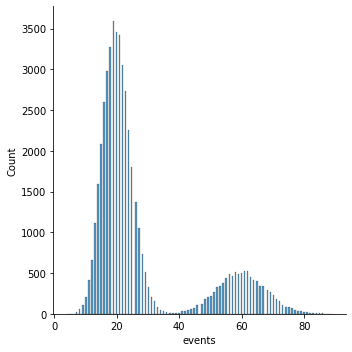

In [26]:
sns.displot(df_c.events)

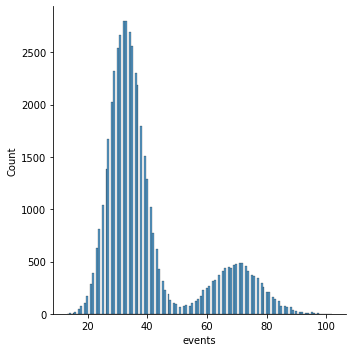

In [27]:
sns.displot(df_t.events)

Посчитаем среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя.

In [31]:
df_t.groupby('segment').describe()

id                                                               \
           count        mean           std   min       25%      50%       75%   
segment                                                                         
high     10000.0  50126.6206  28821.133487  14.0  25317.50  50234.5  74783.25   
low      40000.0  49913.3436  28917.383492   1.0  24763.75  49706.5  75127.25   

                   events                                                      
             max    count       mean       std   min   25%   50%   75%    max  
segment                                                                        
high     99996.0  10000.0  69.938500  8.403974  40.0  64.0  70.0  76.0  102.0  
low      99995.0  40000.0  33.025925  5.720845  13.0  29.0  33.0  37.0   59.0

In [32]:
df_c.groupby('segment').describe()

id                                                               \
           count        mean           std   min       25%      50%       75%   
segment                                                                         
high     10000.0  50473.9782  28761.438914  10.0  25612.50  51031.0  75261.25   
low      40000.0  49935.2567  28855.849243   0.0  25022.25  49944.5  74874.25   

                   events                                                     
             max    count       mean       std   min   25%   50%   75%   max  
segment                                                                       
high     99976.0  10000.0  59.970800  7.805347  31.0  55.0  60.0  65.0  89.0  
low      99999.0  40000.0  20.031575  4.473576   4.0  17.0  20.0  23.0  41.0

Составим формулу для модели: проверяем эффект нескольких переменных (group и segment) на events, с взаимодействием факторов.\
Синтаксис формулы:
    - значком тильды ~ разделяются ЗП и НП
    - ЗП слева, НП справа
    - двоеточием обозначается взаимодействие факторов
Проводим тест

In [33]:
results = smf.ols(formula = 'events ~ segment + group + segment:group', data=df).fit()
an = sm.stats.anova_lm(results, typ = 2)
print(an)

                     sum_sq       df              F         PR(>F)
segment        2.362480e+07      1.0  689756.377484   0.000000e+00
group          3.837195e+06      1.0  112031.864119   0.000000e+00
segment:group  3.664244e+04      1.0    1069.823273  2.060261e-233
Residual       3.424956e+06  99996.0            NaN            NaN


In [21]:
df['combination'] = df['group'] + ' \ ' + df['segment']

In [22]:
df

,id,group,segment,events,combination
0,83440,test,high,78.0,test \ high
1,96723,test,high,71.0,test \ high
2,68719,test,high,80.0,test \ high
3,50399,test,high,80.0,test \ high
4,95613,test,high,78.0,test \ high
...,...,...,...,...,...
99995,60695,control,low,15.0,control \ low
99996,5934,control,low,16.0,control \ low
99997,30046,control,low,22.0,control \ low
99998,26474,control,low,21.0,control \ low


Используем критерий Тьюки, чтобы понять между какими группами были обнаружены статистически значимые различия

In [23]:
pairwise_tukeyhsd(df.events, df.combination).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control \ high,control \ low,-39.9392,0.001,-40.1073,-39.7711,True
control \ high,test \ high,9.9677,0.001,9.7551,10.1803,True
control \ high,test \ low,-26.9449,0.001,-27.113,-26.7768,True
control \ low,test \ high,49.9069,0.001,49.7388,50.075,True
control \ low,test \ low,12.9944,0.001,12.888,13.1007,True
test \ high,test \ low,-36.9126,0.001,-37.0807,-36.7445,True


Для обоих сегментов показатели статистически значимо увеличились по сравнению с контрольной группой. Разница между control/high и test/high составила около 10. Разница между значением у тестовой группы сегмента low и контрольной группой этого же сегмента равна примерно 13.

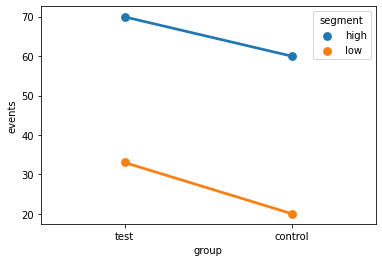

In [24]:
sns.pointplot(x='group', y='events', hue = 'segment', data = df)

Все факторы (group, segment, а также их взаимодействие) оказались значимыми. Судя по графику, для всех групп среднее значение events увеличилось, поэтому выкатываем новую версию.